In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Energy_consumption_India_2.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [4]:
df.tail()

,States,Regions,latitude,longitude,Dates,Usage
16594,Manipur,NER,24.799971,93.950017,05/12/2020 00:00:00,2.5
16595,Meghalaya,NER,25.570492,91.880014,05/12/2020 00:00:00,5.8
16596,Mizoram,NER,23.710399,92.720015,05/12/2020 00:00:00,1.6
16597,Nagaland,NER,25.666998,94.116570,05/12/2020 00:00:00,2.1
16598,Tripura,NER,23.835404,91.279999,05/12/2020 00:00:00,3.3


In [5]:
df.shape

(16599, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   States     16599 non-null  object 
 1   Regions    16599 non-null  object 
 2   latitude   16599 non-null  float64
 3   longitude  16599 non-null  float64
 4   Dates      16599 non-null  object 
 5   Usage      16599 non-null  float64
dtypes: float64(3), object(3)
memory usage: 778.2+ KB


In [7]:
df.isnull().sum()

States       0
Regions      0
latitude     0
longitude    0
Dates        0
Usage        0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['Dates'])

In [9]:
plt.rcParams['figure.figsize'] = [15,8]

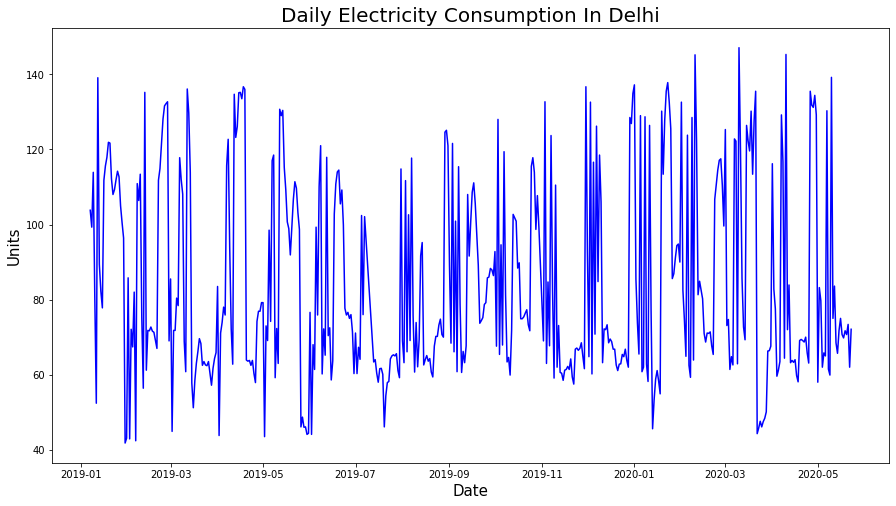

In [10]:
df_del = df[df['States'] == 'Delhi']
df_del_grp = df_del.groupby('date').agg({'Usage':'sum'})
plt.plot(df_del_grp,color='blue',linewidth=1.5)
plt.title('Daily Electricity Consumption In Delhi',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [11]:
len(df_del_grp)

498

In [12]:
time = pd.date_range(start='1/7/2019',periods=498,freq='D')

In [13]:
df_del_grp.set_index(time,inplace=True)

In [14]:
df_del_grp

,Usage
2019-01-07,103.8
2019-01-08,99.3
2019-01-09,113.9
2019-01-10,80.7
2019-01-11,52.4
...,...
2020-05-14,71.7
2020-05-15,70.7
2020-05-16,73.4
2020-05-17,62.0


In [15]:
df = df_del_grp.copy()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [29]:
#Split data set into testing dataset and train dataset
train_size = 450
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 6
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(444, 6)
(444,)
(42, 6)
(42,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 26.0 MB/s 


In [20]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='del_consum')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 40s]
val_mape: 26.14543914794922

Best val_mape So Far: 12.837466716766357
Total elapsed time: 00h 11m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/del_consum
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 8
units_0: 200
dropout: False
learning_rate: 0.013545428081737601
units_1: 224
units_2: 40
Dropout_rate: 0.4
units_3: 192
units_4: 112
units_5: 248
units_6: 24
units_7: 72
units_8: 72
units_9: 192
Score: 12.837466716766357
Trial summary
Hyperparameters:
num_layers: 6
units_0: 248
dropout: False
learning_rate: 0.008294173681456725
units_1: 96
units_2: 160
Dropout_rate: 0.0
units_3: 152
units_4: 176
units_5: 32
units_6: 192
units_7: 80
units_8: 232
units_9: 72
Score: 13.272140502929688
Trial summary
Hyperparameters:
num_layers: 5
units_0: 64
dropout: True
learning_rate: 0.009008415865811041
units_1: 168
units_2: 168
Dropout_rate: 0.0
units_3: 160
units_4: 32
units_5: 24
units_6: 208
units_7: 16
units_8: 200
units_9: 40
Score: 13.335609912872314
Trial summary
Hyperparameters:
num_layers: 8
units_0: 112
dropout: False
learning_rate: 0.0

In [21]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 6))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1400      
                                                                 
 dense_1 (Dense)             (None, 224)               45024     
                                                                 
 dense_2 (Dense)             (None, 40)                9000      
                                                                 
 dense_3 (Dense)             (None, 192)               7872      
                                                                 
 dense_4 (Dense)             (None, 112)               21616     
                                                                 
 dense_5 (Dense)             (None, 248)               28024     
                                                                 
 dense_6 (Dense)             (None, 24)                5

In [22]:
from tensorflow.keras import optimizers

In [30]:
model = Sequential()
model.add(Dense(128,activation='relu',input_dim = 6))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00019545428081737601)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 200)

Epoch 1/200
14/14 [==============================] - 1s 24ms/step - loss: 93.0284 - mape: 93.0284 - val_loss: 83.4491 - val_mape: 83.4491
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 74.0915 - mape: 74.0915 - val_loss: 60.9921 - val_mape: 60.9921
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 50.7388 - mape: 50.7388 - val_loss: 34.9392 - val_mape: 34.9392
Epoch 4/200
14/14 [==============================] - 0s 5ms/step - loss: 29.4678 - mape: 29.4678 - val_loss: 20.6828 - val_mape: 20.6828
Epoch 5/200
14/14 [==============================] - 0s 7ms/step - loss: 24.3370 - mape: 24.3370 - val_loss: 22.4896 - val_mape: 22.4896
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 24.0211 - mape: 24.0211 - val_loss: 20.8210 - val_mape: 20.8210
Epoch 7/200
14/14 [==============================] - 0s 5ms/step - loss: 23.4040 - mape: 23.4040 - val_loss: 19.7211 - val_mape: 19.7211
Epoch 8/200
14/14 [=====================

In [27]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : 15.35
Test MAPE : 15.98


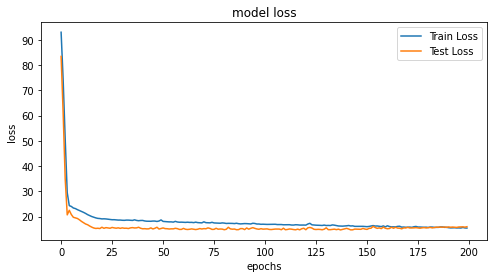

In [31]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train MAPE : %.2f'% (train_score[1]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test MAPE : %.2f'% (test_score[1]))
model_loss(model_history)

In [32]:
import seaborn as sns

In [33]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(444,486)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

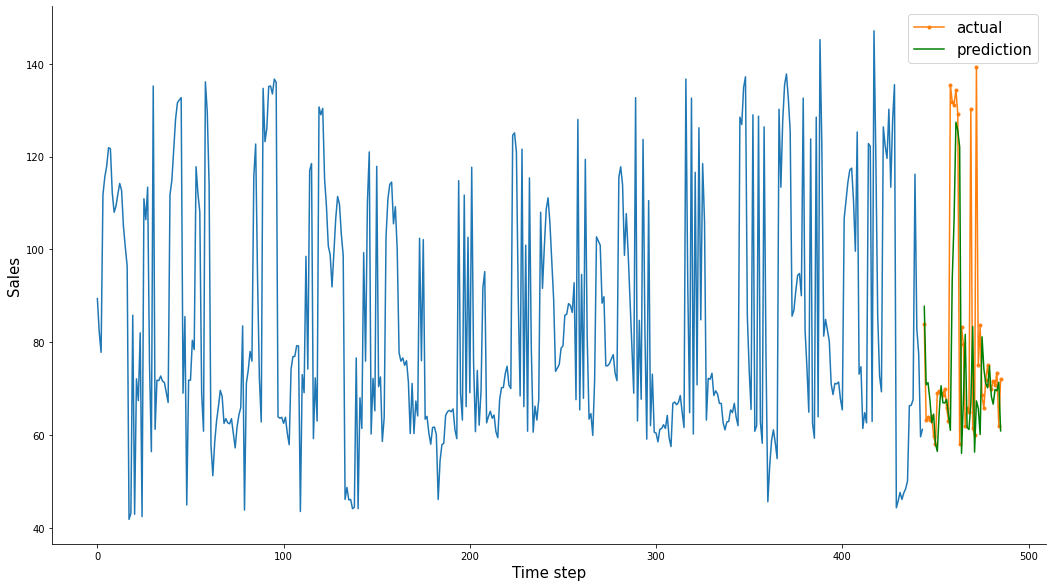

In [34]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)